In [9]:
import torch
from dataloaders.brats2021 import BRATS2021EncoderSegDataset
from glob import glob
from gridencoder import GridEncoder

import torch
from torch import nn
%pylab
%matplotlib notebook

Using matplotlib backend: <object object at 0x7fa0bfae56c0>
Populating the interactive namespace from numpy and matplotlib


In [2]:
encoder = GridEncoder(level_dim=4, desired_resolution=196, gridtype='tiled', align_corners=True).cuda()
decoder = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 4)
).cuda()
decoder.load_state_dict(torch.load('/data/Implicit3DCNNTasks/brats2021/decoder.pth'))

<All keys matched successfully>

In [3]:
encoders = glob("/data/Implicit3DCNNTasks/brats2021/encoder_BraTS2021_*pth")

In [16]:
idx = int(input("Enter index: "))
enc = encoders[idx]
encoder.load_state_dict(torch.load(enc))

# run eval
HWD = torch.tensor([240, 240, 155]).long()
xyz = torch.meshgrid([torch.arange(t) for t in HWD], indexing='ij')
xyz = torch.stack(xyz, dim=-1).reshape(-1, 3)
xyz = xyz / (HWD - 1) * 2 - 1

with torch.no_grad():
    imgs = []
    sz = xyz.shape[0]//8
    for i in range(8):
        minixyz = xyz[sz*i:sz*(i+1)].cuda()
        img = decoder(encoder(minixyz))
        imgs.append(img)
        
imgs = torch.stack(imgs, dim=0).reshape(240, 240, 155, 4)

Enter index: 5


<IPython.core.display.Javascript object>


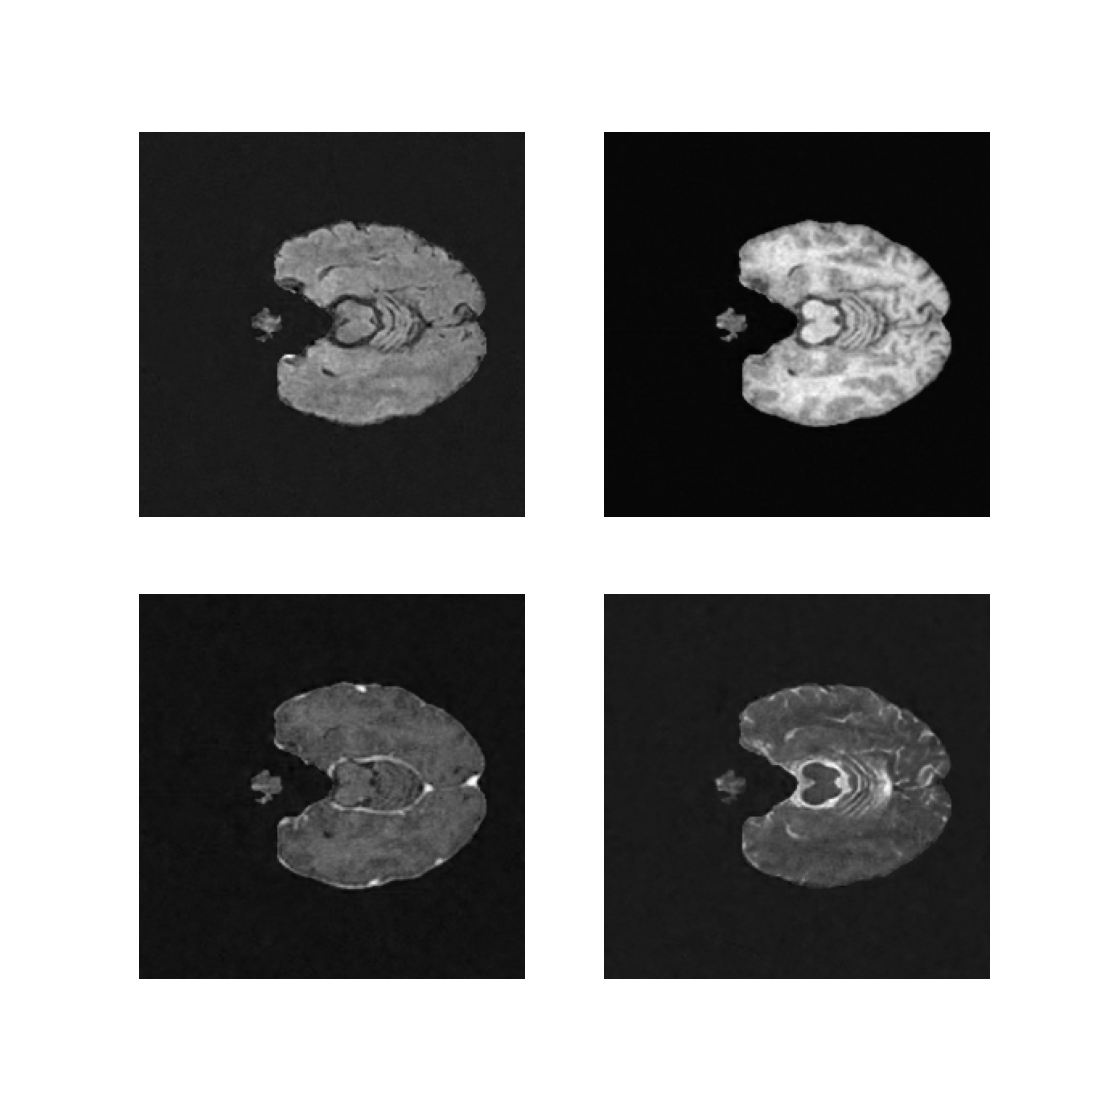

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axs[i][j].imshow(imgs[:, :, 50, i*2 + j].data.cpu().numpy(), cmap='gray')
        axs[i][j].axis('off')